In [209]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


## Data Import

In [210]:
X = pd.read_csv('data/x_train.csv')
y = pd.read_csv('data/y_train.csv')
X_test = pd.read_csv('data/x_test.csv')

In [211]:
df = X.merge(y, on= 'ID').drop(['ID', 'DAY_ID'], axis= 1)
y.drop('ID', axis=1, inplace=True)

## Divide FR and DE + Small Data Cleaning

In [212]:
# change country selection for de/fr models
fr = df[df['COUNTRY'] == 'FR'].drop(['COUNTRY'], axis=1).sort_index().fillna(0)  

#PCA requires full rank so we remove linearly dependent variables 
d = ['DE_FR_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT']
fr.drop(columns=d, axis=1, inplace=True)


fr_y = fr['TARGET']
fr_X = fr.drop(columns=['TARGET'], axis=1)


## PCA Transformation

In [213]:
n = 10

pca = PCA(n_components=n)
X_pca = pca.fit_transform(fr_X)

pca.explained_variance_ratio_

array([0.24969529, 0.16449326, 0.10125615, 0.0729042 , 0.06012852,
       0.04971018, 0.03737102, 0.03388026, 0.03253571, 0.03169299])

## LightGBoost Training and Summary

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, fr_y, test_size=0.3, random_state=42)

params = {
    'task': 'train',
    'boosting_type': 'rf', 
    'objective': 'huber', 
    "learning_rate": 0.1,
    "num_leaves": 180,
    "feature_fraction": 0.8,
    'verbose': -1
}


train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

fr_model = lgb.train(
    params = params,
    train_set = train_data,
    num_boost_round=2000)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

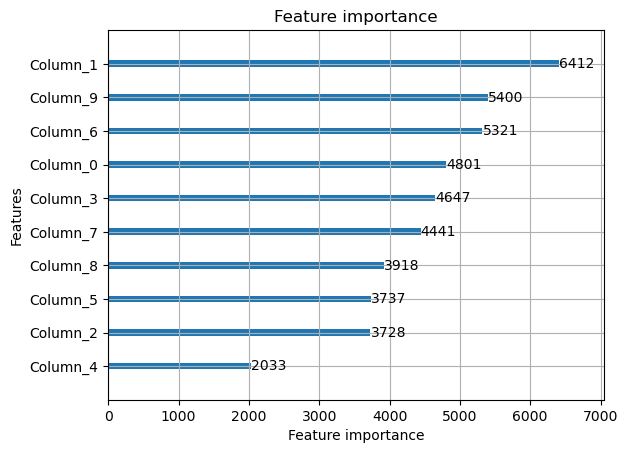

In [215]:
lgb.plot_importance(fr_model)

### Evaluation

In [216]:
y_pred = fr_model.predict(X_test)

# Calculate Spearman correlation with y_test
from scipy.stats import spearmanr
spearman_corr, _ = spearmanr(y_test, y_pred)


spearman_corr

0.08650686772339126

## Takeaways

- PCA is not useful in this case, too many outliers and sparse data
- Huber loss + Random forest boosting might be good for France
- MAE or MAPE + DART Boosting might be good for Germany
- France Target is particularly hard to model even with nonlinear approach -> variance stabilization needed
- Yeo-Johnson not effective, france target still leptokurtic, kurtosis 14 -> 12
- Risk of overfitting, L2 might help